<a href="https://colab.research.google.com/github/IT22312976/25-26j--340/blob/main/night_time_animal_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Ultralytics YOLOv8
!pip install ultralytics -q

# Imports
import os
import shutil
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
from IPython.display import Image, display
from google.colab import drive

# Configure matplotlib
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the base directory (Update if your path is different)
BASE_DIR = '/content/drive/My Drive/data_vithya_night_time_animal_detection/data'

# Define subdirectories
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Class names extracted from the training annotations
CLASSES = [
    'Sable', 'Weasel', 'AmurTiger', 'MuskDeer', 'LeopardCat', 'RaccoonDog',
    'Hare', 'Leopard', 'RedFox', 'SikaDeer', 'RoeDeer', 'Badger',
    'WildBoar', 'Cow', 'BlackBear', 'Y-T-Marten', 'Dog'
]

# Create a mapping from class name to ID
CLASS_MAP = {name: idx for idx, name in enumerate(CLASSES)}

print("Configuration Loaded.")
print(f"Base Directory: {BASE_DIR}")
print(f"Classes: {CLASSES}")

Configuration Loaded.
Base Directory: /content/drive/My Drive/data_vithya_night_time_animal_detection/data
Classes: ['Sable', 'Weasel', 'AmurTiger', 'MuskDeer', 'LeopardCat', 'RaccoonDog', 'Hare', 'Leopard', 'RedFox', 'SikaDeer', 'RoeDeer', 'Badger', 'WildBoar', 'Cow', 'BlackBear', 'Y-T-Marten', 'Dog']


In [ ]:
def convert_csv_to_yolo_labels(csv_path, images_dir):
    """
    Reads annotations from a CSV file and creates YOLO format .txt label files
    inside the images directory.
    """
    if not os.path.exists(csv_path):
        print(f"Error: Annotation file not found at {csv_path}")
        return

    print(f"Processing annotations from: {csv_path}")
    df = pd.read_csv(csv_path)

    # Group by filename since one image can have multiple objects
    grouped = df.groupby('filename')

    count = 0
    for filename, group in grouped:
        # Construct the label file path (same name as image but .txt)
        label_filename = os.path.splitext(filename)[0] + '.txt'
        label_path = os.path.join(images_dir, label_filename)

        with open(label_path, 'w') as f:
            for _, row in group.iterrows():
                class_name = row['class']

                # Skip if class is not in our defined list
                if class_name not in CLASS_MAP:
                    continue

                class_id = CLASS_MAP[class_name]
                img_width = row['width']
                img_height = row['height']

                # Convert to normalized YOLO coordinates
                # Format: class_id center_x center_y width height
                x_center = ((row['xmin'] + row['xmax']) / 2) / img_width
                y_center = ((row['ymin'] + row['ymax']) / 2) / img_height
                width = (row['xmax'] - row['xmin']) / img_width
                height = (row['ymax'] - row['ymin']) / img_height

                # Write to file
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
        count += 1

    print(f"Successfully generated {count} label files in {images_dir}")

# Execute the conversion
convert_csv_to_yolo_labels(os.path.join(BASE_DIR, 'train_annotations.csv'), TRAIN_DIR)
convert_csv_to_yolo_labels(os.path.join(BASE_DIR, 'valid_annotations.csv'), VAL_DIR)
convert_csv_to_yolo_labels(os.path.join(BASE_DIR, 'test_annotations.csv'), TEST_DIR)

Processing annotations from: /content/drive/My Drive/data_vithya_night_time_animal_detection/data/train_annotations.csv
Successfully generated 6778 label files in /content/drive/My Drive/data_vithya_night_time_animal_detection/data/train
Processing annotations from: /content/drive/My Drive/data_vithya_night_time_animal_detection/data/valid_annotations.csv
Successfully generated 1948 label files in /content/drive/My Drive/data_vithya_night_time_animal_detection/data/valid
Processing annotations from: /content/drive/My Drive/data_vithya_night_time_animal_detection/data/test_annotations.csv
Successfully generated 965 label files in /content/drive/My Drive/data_vithya_night_time_animal_detection/data/test


In [ ]:
def create_data_yaml(output_path):
    """
    Creates the data.yaml file required by YOLOv8.
    """
    data_config = {
        'path': BASE_DIR,       # Root directory
        'train': 'train',       # Train images (relative to path)
        'val': 'valid',         # Validation images (relative to path)
        'test': 'test',         # Test images (relative to path)
        'names': {idx: name for idx, name in enumerate(CLASSES)},
        'nc': len(CLASSES)
    }

    with open(output_path, 'w') as f:
        yaml.dump(data_config, f, default_flow_style=False)

    print(f"data.yaml created at: {output_path}")

# Create the yaml file
yaml_path = os.path.join(BASE_DIR, 'data.yaml')
create_data_yaml(yaml_path)

data.yaml created at: /content/drive/My Drive/data_vithya_night_time_animal_detection/data/data.yaml


In [ ]:
def train_model(data_yaml_path, epochs=25, image_size=640):
    """
    Trains the YOLOv8 model.
    """
    # Load a pre-trained model (yolov8n.pt is the 'nano' version, fastest)
    # You can change to 'yolov8s.pt' or 'yolov8m.pt' for better accuracy but slower training
    model = YOLO('yolov8n.pt')

    print("Starting training...")
    results = model.train(
        data=data_yaml_path,
        epochs=epochs,
        imgsz=image_size,
        project='/content/runs',  # Save results in Colab runtime
        name='animal_detection',   # Name of the sub-folder
        exist_ok=True              # Overwrite existing if name exists
    )

    # Save the best model to your Drive so you don't lose it
    best_model_path = '/content/runs/animal_detection/weights/best.pt'
    destination_path = os.path.join(BASE_DIR, 'best_animal_detector.pt')

    if os.path.exists(best_model_path):
        shutil.copy(best_model_path, destination_path)
        print(f"Training Complete. Best model saved to Drive at: {destination_path}")

    return model, '/content/runs/animal_detection'

# Run Training
trained_model, run_folder_path = train_model(yaml_path, epochs=10)

Starting training...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/data_vithya_night_time_animal_detection/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=animal_detection, nbs=64, nms=False, opset=None, optimize=False, opt

--- Evaluation Metrics from /content/runs/animal_detection ---

Displaying results.png:


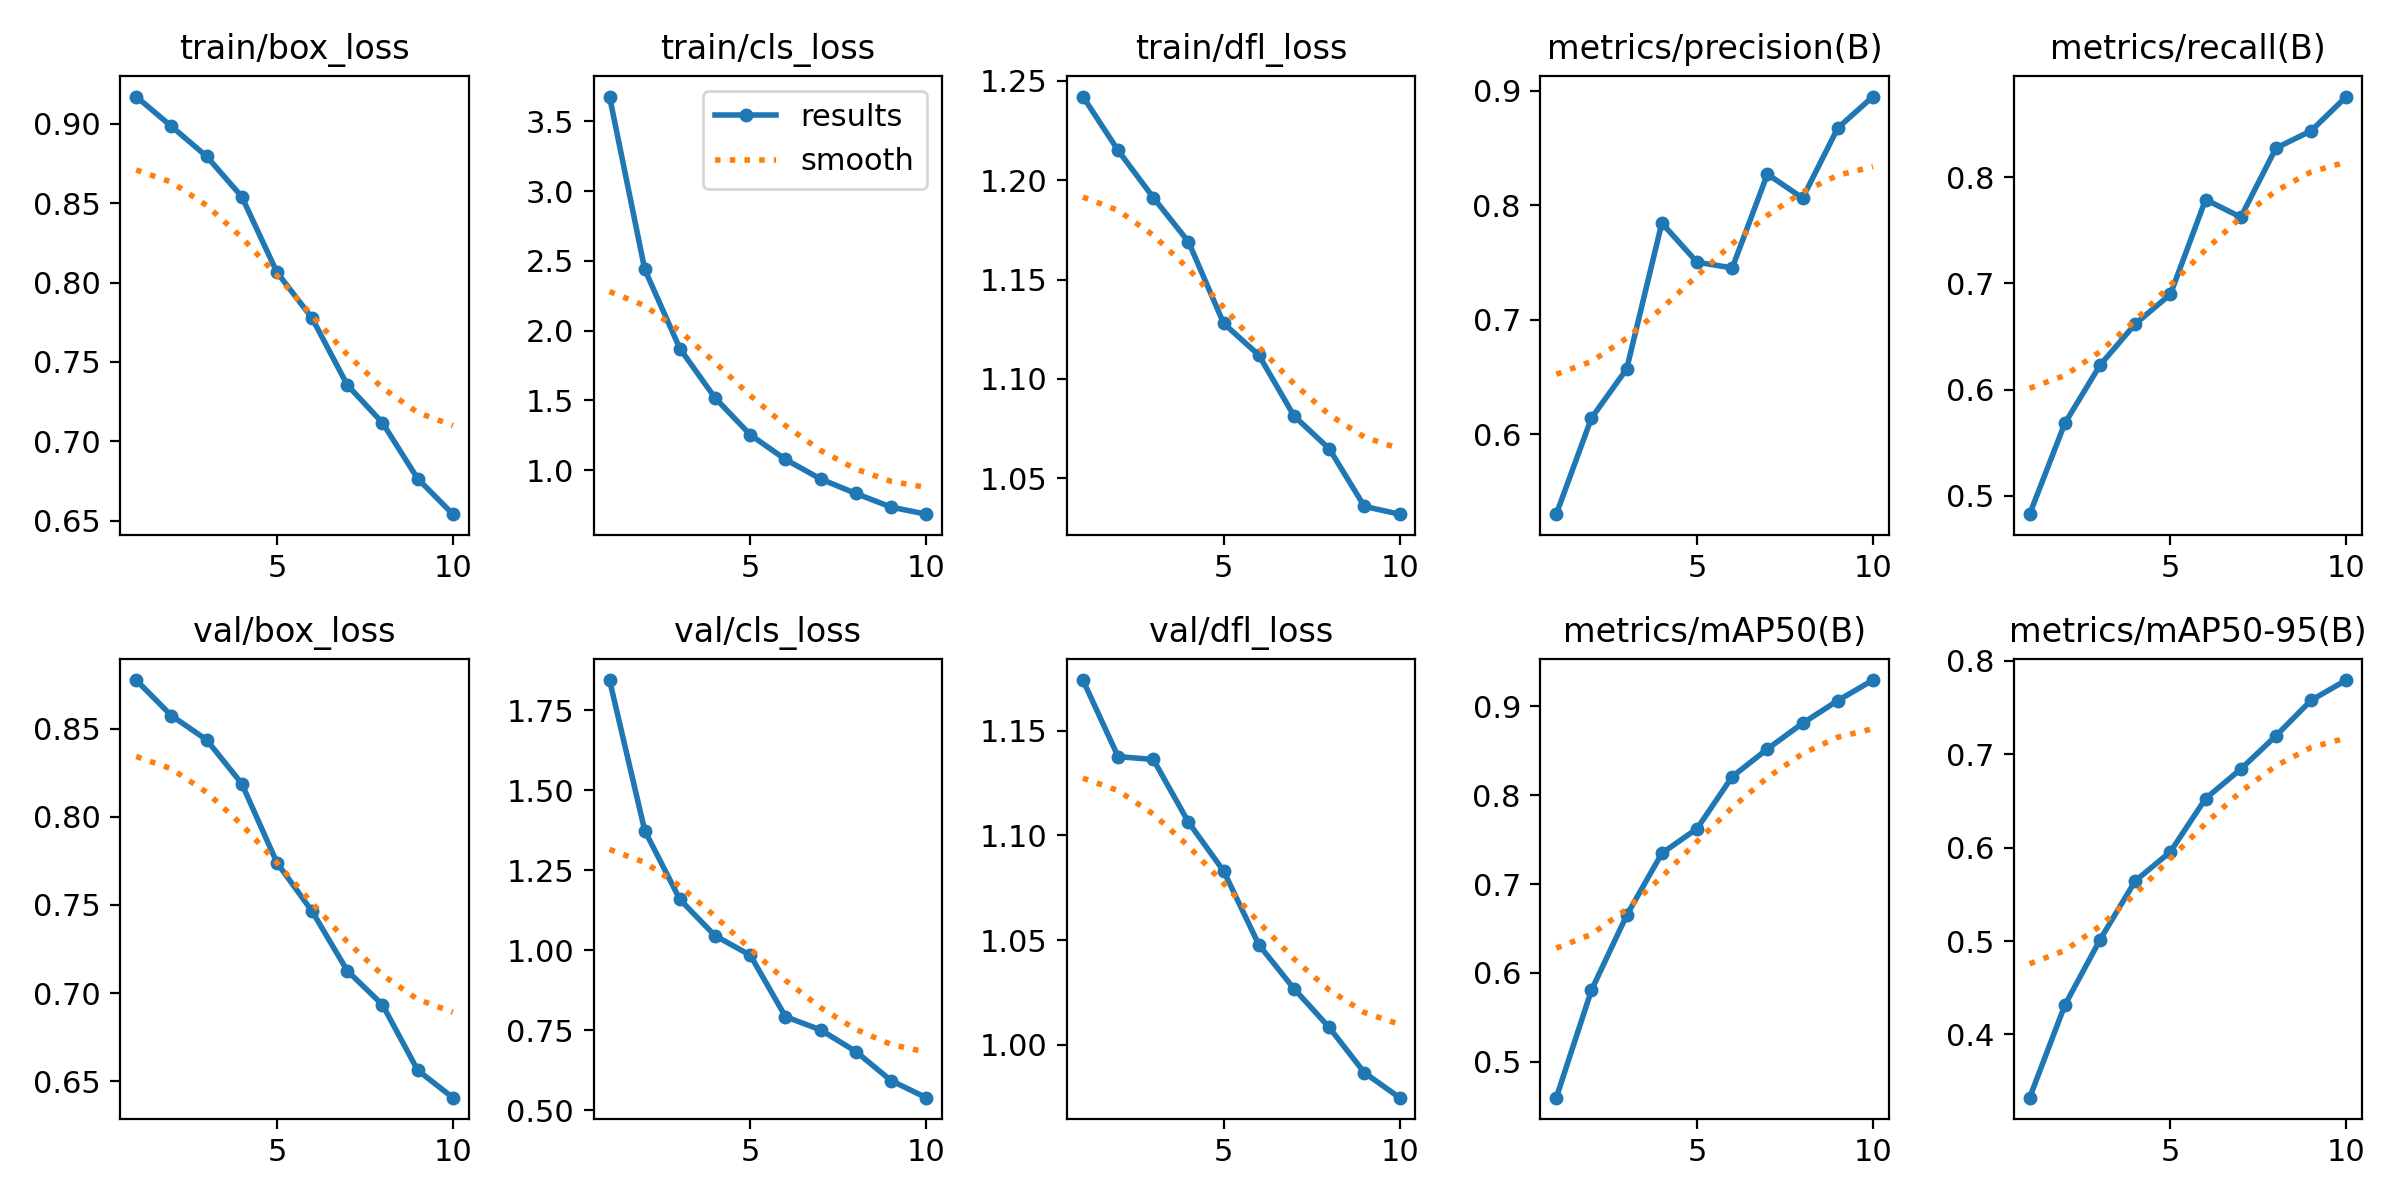


Displaying confusion_matrix.png:


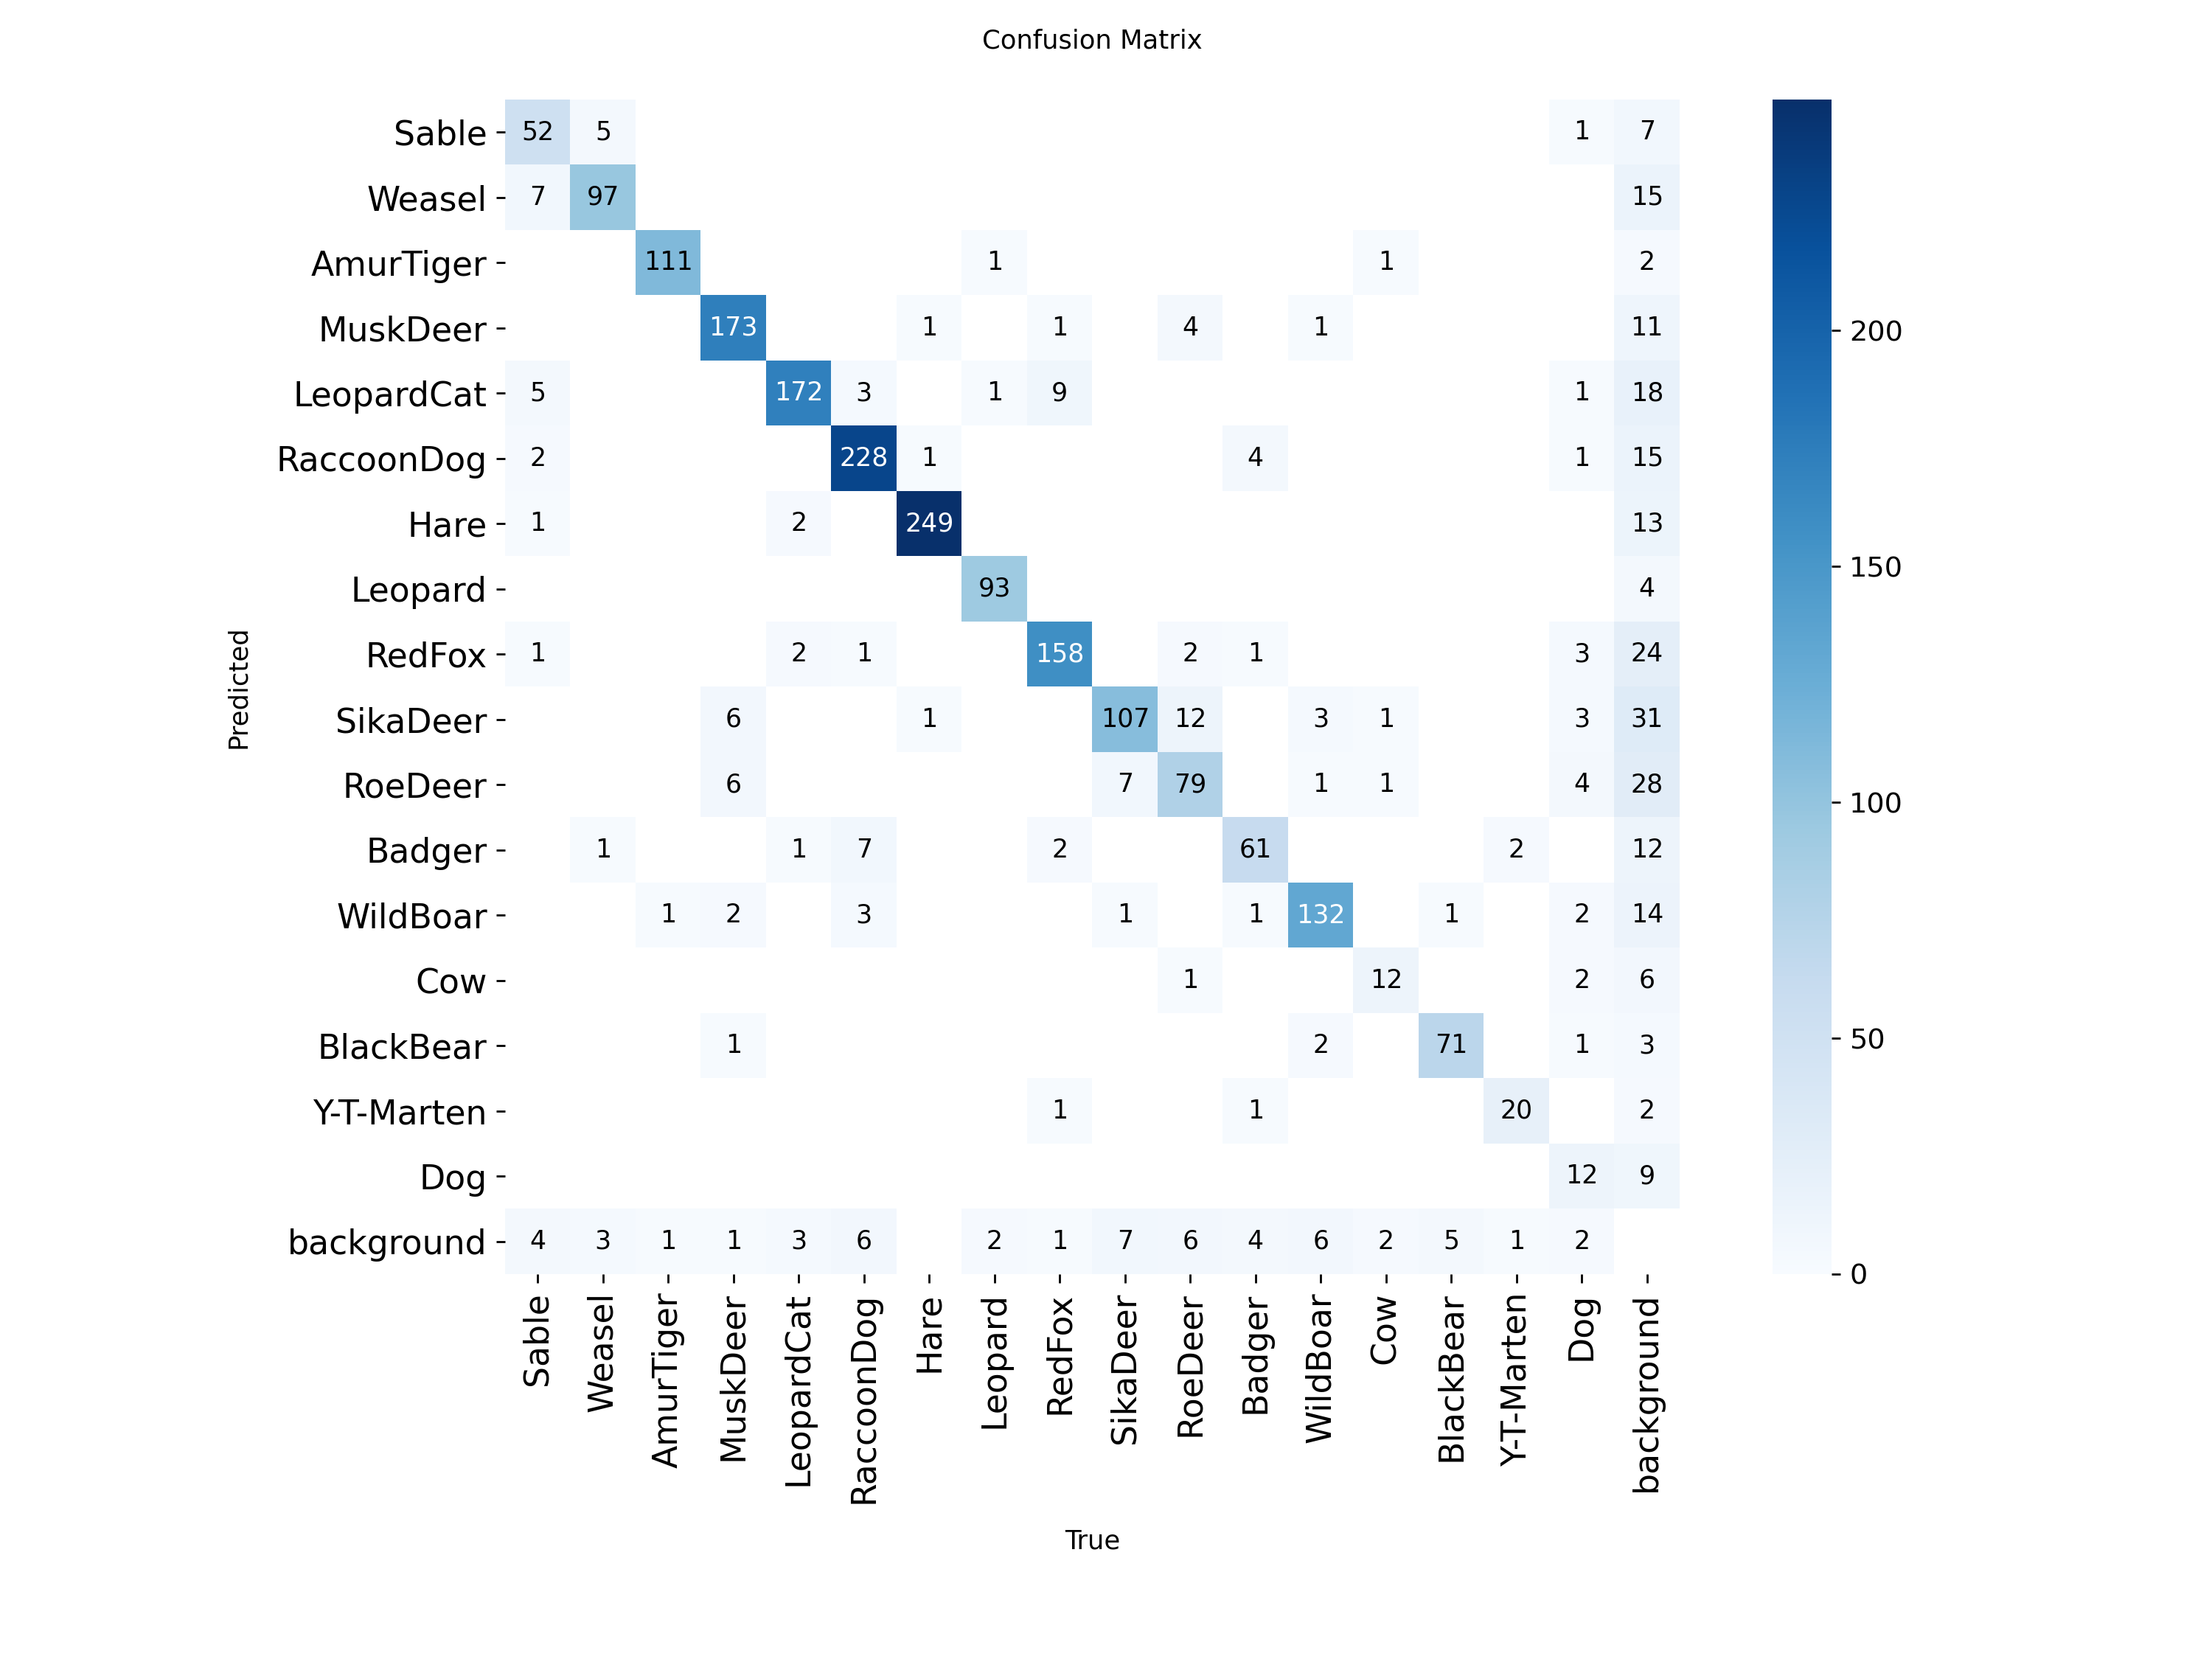

File F1_curve.png not found (might not be generated yet or training failed).
File PR_curve.png not found (might not be generated yet or training failed).


In [ ]:
def show_evaluation_metrics(run_folder):
    """
    Displays evaluation graphs and metrics from the training run.
    """
    print(f"--- Evaluation Metrics from {run_folder} ---")

    # Files typically generated by YOLOv8
    files_to_show = [
        'results.png',           # Loss and accuracy curves
        'confusion_matrix.png',  # Confusion Matrix
        'F1_curve.png',          # F1 Score curve
        'PR_curve.png'           # Precision-Recall curve
    ]

    for file_name in files_to_show:
        file_path = os.path.join(run_folder, file_name)
        if os.path.exists(file_path):
            print(f"\nDisplaying {file_name}:")
            display(Image(filename=file_path, width=800))
        else:
            print(f"File {file_name} not found (might not be generated yet or training failed).")

# Show metrics
show_evaluation_metrics(run_folder_path)


image 1/1 /content/drive/My Drive/data_vithya_night_time_animal_detection/data/test/AmurLeopard_1186_jpg.rf.791537145223666076ac8dfcadc9db5a.jpg: 640x640 1 Leopard, 13.0ms
Speed: 2.3ms preprocess, 13.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


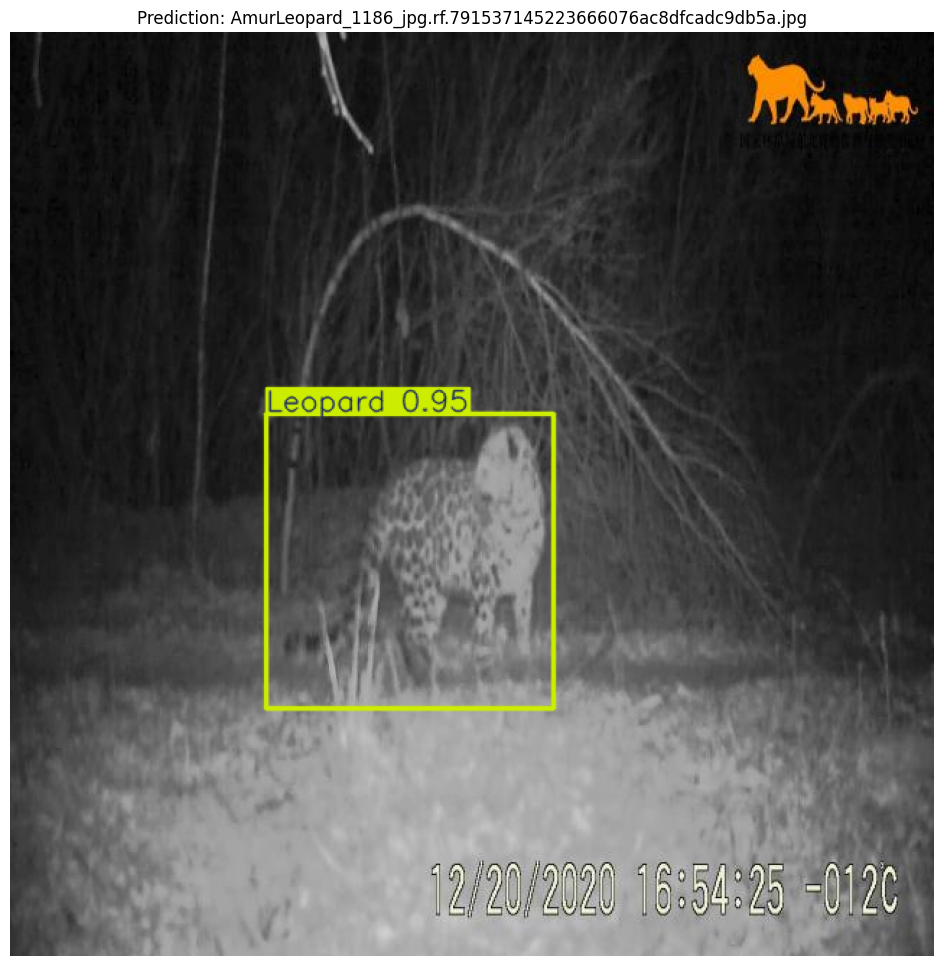

In [ ]:
def predict_new_image(model_path, image_path):
    """
    Loads the model and predicts objects in the given image.
    """
    # Load the model
    model = YOLO(model_path)

    # Predict
    # conf=0.25 sets the confidence threshold
    results = model.predict(image_path, conf=0.25)

    # Display Result
    for result in results:
        # Plot predictions on the image (returns numpy array)
        im_array = result.plot()

        # Convert BGR (OpenCV format) to RGB (Matplotlib format)
        im_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(12, 12))
        plt.imshow(im_rgb)
        plt.axis('off')
        plt.title(f"Prediction: {os.path.basename(image_path)}")
        plt.show()

# Example Usage:
# Replace 'test_image.jpg' with an actual image file from your Test folder
test_image_path = os.path.join(TEST_DIR, 'AmurLeopard_1186_jpg.rf.791537145223666076ac8dfcadc9db5a.jpg')
predict_new_image(os.path.join(BASE_DIR, 'best_animal_detector.pt'), test_image_path)

In [ ]:
/content/drive/MyDrive/data_vithya_night_time_animal_detection/data/test/AmurLeopard_1186_jpg.rf.791537145223666076ac8dfcadc9db5a.jpg